In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error


/tmp/ipykernel_1038/1142746155.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
ratingDF = pd.read_csv('../raw_data/ratings.csv')

In [4]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: now.strftime("%m/%d/%Y, %H:%M:%S"))

In [5]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,"02/07/2024, 10:19:12"
1,1,3,4.0,"02/07/2024, 10:19:12"
2,1,6,4.0,"02/07/2024, 10:19:12"
3,1,47,5.0,"02/07/2024, 10:19:12"
4,1,50,5.0,"02/07/2024, 10:19:12"


In [6]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
"rating",ascending=False)[0:500].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       43734
movieId      43734
rating       43734
timestamp    43734
dtype: int64

In [7]:
ratingDFX2.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,"02/07/2024, 10:19:12"
1,1,3,4.0,"02/07/2024, 10:19:12"
2,1,6,4.0,"02/07/2024, 10:19:12"
3,1,47,5.0,"02/07/2024, 10:19:12"
4,1,50,5.0,"02/07/2024, 10:19:12"


In [8]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
"rating",ascending=False).sample(n=500, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       36416
movieId      36416
rating       36416
timestamp    36416
dtype: int64

In [88]:
max(ratingDFX3.userId)

610

In [10]:
X_train, X_test = train_test_split(ratingDFX3,
test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test,
test_size=0.50, shuffle=True, random_state=2018)

In [11]:
X_train

,userId,movieId,rating,timestamp
5691,41,1307,3.5,"02/07/2024, 10:19:12"
66065,425,2692,4.0,"02/07/2024, 10:19:12"
15124,97,1961,2.0,"02/07/2024, 10:19:12"
88919,573,58559,5.0,"02/07/2024, 10:19:12"
64515,414,45447,3.0,"02/07/2024, 10:19:12"
...,...,...,...,...
48927,317,70286,2.0,"02/07/2024, 10:19:12"
98500,607,353,3.0,"02/07/2024, 10:19:12"
25583,177,54001,5.0,"02/07/2024, 10:19:12"
50723,328,1196,5.0,"02/07/2024, 10:19:12"


In [12]:
n_users = ratingDFX3.userId.unique().shape[0] + 1
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

In [13]:
ratings_train = np.zeros((n_users, n_movies))

In [14]:
ratings_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X_train['user_index'] = X_train['userId'].apply(lambda x: list(ratingDFX3.userId.unique()).index(x))
X_train['movie_index'] = X_train['movieId'].apply(lambda x: list(ratingDFX3.movieId.unique()).index(x))


In [16]:
for index, row in X_train.iterrows():
    ratings_train[row['user_index'], row['movie_index']] = row['rating']

In [17]:
X_validation['user_index'] = X_validation['userId'].apply(lambda x: list(ratingDFX3.userId.unique()).index(x))
X_validation['movie_index'] = X_validation['movieId'].apply(lambda x: list(ratingDFX3.movieId.unique()).index(x))

In [18]:
X_test['user_index'] = X_test['userId'].apply(lambda x: list(ratingDFX3.userId.unique()).index(x))
X_test['movie_index'] = X_test['movieId'].apply(lambda x: list(ratingDFX3.movieId.unique()).index(x))

In [70]:
X_test

,userId,movieId,rating,timestamp,user_index,movie_index
87135,562,1393,3.5,"02/07/2024, 10:19:12",458,493
81573,517,594,3.5,"02/07/2024, 10:19:12",418,245
11057,68,5418,4.5,"02/07/2024, 10:19:12",53,367
40710,275,1517,3.0,"02/07/2024, 10:19:12",220,67
19095,122,106782,5.0,"02/07/2024, 10:19:12",99,135
...,...,...,...,...,...,...
87832,567,3114,3.5,"02/07/2024, 10:19:12",463,260
58950,384,3994,4.0,"02/07/2024, 10:19:12",315,263
24187,167,5952,4.5,"02/07/2024, 10:19:12",138,281
45207,298,68954,3.0,"02/07/2024, 10:19:12",238,338


In [19]:
ratings_validation = np.zeros((n_users, n_movies))
for index, row in X_validation.iterrows():
    ratings_validation[row['user_index'], row['movie_index']] = row['rating']

In [18]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [19]:
actual_validation

array([4., 3., 4., ..., 4., 5., 4.])

In [20]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [21]:
mean_squared_error(pred_validation, actual_validation)

1.0023338824821526

In [20]:
import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

2024-02-07 10:21:37.330658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 10:21:37.330774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 10:21:37.416058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 10:21:37.582424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 10:21:40.050370: W tensorflow/compiler/tf2

In [21]:
n_latent_factors = 1
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors,
name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1,
output_dim=n_latent_factors,
name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie_embedding (Embedding  (None, 1, 1)                 501       ['movie[0][0]']               
 )                                                                                                
                                                                                                  
 user_embedding (Embedding)  (None, 1, 1)                 502       ['user[0][0]']            

In [23]:
history = model.fit(x=[X_train.user_index, X_train.movie_index],
                    y=X_train.rating, epochs=100,
                    validation_data=([X_validation.user_index,
                                      X_validation.movie_index], X_validation.rating),
                    verbose=1)

Epoch 1/100
1025/1025 [==============================] - 5s 4ms/step - loss: 14.6389 - val_loss: 14.2235
Epoch 2/100
1025/1025 [==============================] - 3s 3ms/step - loss: 12.9883 - val_loss: 11.4224
Epoch 3/100
1025/1025 [==============================] - 4s 4ms/step - loss: 9.7253 - val_loss: 8.0361
Epoch 4/100
1025/1025 [==============================] - 4s 4ms/step - loss: 6.5168 - val_loss: 5.1994
Epoch 5/100
1025/1025 [==============================] - 4s 4ms/step - loss: 4.1523 - val_loss: 3.3526
Epoch 6/100
1025/1025 [==============================] - 4s 4ms/step - loss: 2.7600 - val_loss: 2.3358
Epoch 7/100
1025/1025 [==============================] - 3s 3ms/step - loss: 2.0009 - val_loss: 1.7566
Epoch 8/100
1025/1025 [==============================] - 3s 3ms/step - loss: 1.5488 - val_loss: 1.3880
Epoch 9/100
1025/1025 [==============================] - 3s 3ms/step - loss: 1.2585 - val_loss: 1.1488
Epoch 10/100
1025/1025 [==============================] - 3s 3ms/step

Minimum MSE:  0.6852520108222961


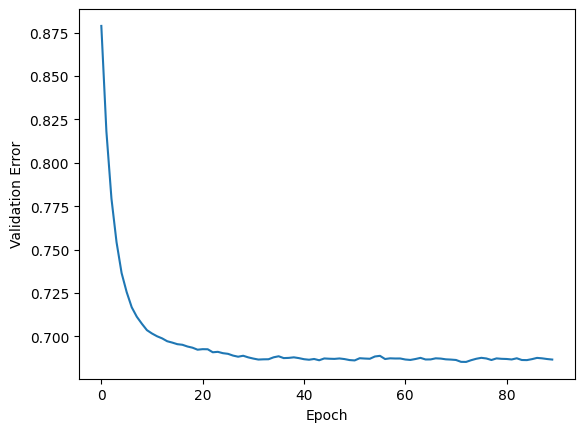

In [26]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [67]:
ratings_train[500, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
y_pred = model.predict([X_test.user_index, X_test.movie_index])

57/57 [==============================] - 0s 3ms/step


In [49]:
y_pred

array([[3.8304446],
       [2.41908  ],
       [3.4789915],
       ...,
       [3.9205272],
       [3.2593176],
       [3.1891346]], dtype=float32)

In [37]:
mean_squared_error(X_test.rating, y_pred)

0.6956618175593245

In [25]:
X_test.user_index.shape

(1821,)

In [50]:
new_user = np.full((len(ratingDFX3.movieId.unique()),), 501)

In [55]:
new_movies = np.linspace(0,500,num=500)

In [75]:
X_new = X_train[0:20]

In [82]:
X_new['user_index'] = 499

/tmp/ipykernel_1038/137201578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['user_index'] = 499


In [83]:
X_test = pd.concat([X_test, X_new])

In [84]:
X_test

,userId,movieId,rating,timestamp,user_index,movie_index
87135,562,1393,3.5,"02/07/2024, 10:19:12",458,493
81573,517,594,3.5,"02/07/2024, 10:19:12",418,245
11057,68,5418,4.5,"02/07/2024, 10:19:12",53,367
40710,275,1517,3.0,"02/07/2024, 10:19:12",220,67
19095,122,106782,5.0,"02/07/2024, 10:19:12",99,135
...,...,...,...,...,...,...
56858,379,339,3.0,"02/07/2024, 10:19:12",499,224
30025,209,51255,4.5,"02/07/2024, 10:19:12",499,489
72022,463,5378,4.0,"02/07/2024, 10:19:12",499,274
10414,68,266,4.0,"02/07/2024, 10:19:12",499,217


In [85]:
y_pred = model.predict([X_test.user_index, X_test.movie_index])

59/59 [==============================] - 0s 3ms/step


In [86]:
y_pred[-20:]

array([[4.2992516],
       [4.4618335],
       [4.406532 ],
       [4.6015306],
       [3.5569186],
       [2.959612 ],
       [4.215093 ],
       [4.3592825],
       [4.3401213],
       [4.648692 ],
       [4.61309  ],
       [4.294754 ],
       [4.197741 ],
       [4.6440964],
       [4.406532 ],
       [3.774219 ],
       [4.487795 ],
       [3.4664543],
       [3.8264585],
       [3.5428655]], dtype=float32)